In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-ultimate-moist-meter-dataset/moistmeter.csv


In [33]:
moist_data = pd.read_csv('/kaggle/input/the-ultimate-moist-meter-dataset/moistmeter.csv', index_col = "ID")
moist_data.head()

,Review Date,Category,Title,IMDB Rating,RT Critics Rating,Moistmeter Rating,Genre
ID,,,,,,,
1,3/26/2017,Video Games,Mass Effect Andromeda,NaN,NaN,55.0,NaN
2,4/3/2017,Movies,Ghost in the Shell,6.3,42.0,70.0,"Action, Crime, Drama"
3,4/9/2017,Video Games,Persona 5,NaN,NaN,85.0,"Animation, Action, Adventure"
4,4/15/2017,Video Games,Drawn to Death,NaN,NaN,45.0,NaN
5,4/17/2017,Video Games,Yooka-Laylee,NaN,NaN,40.0,NaN


At first, I am curious about how Charlie's rating changed over time.

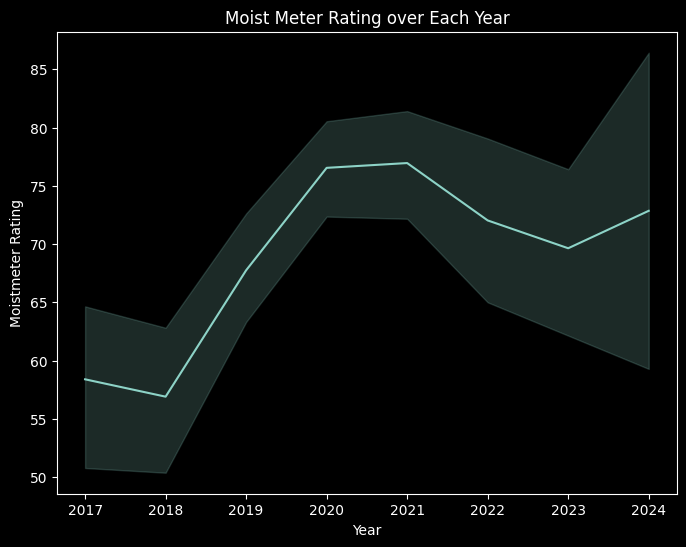

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

moist_data['Review Date'] = pd.to_datetime(moist_data['Review Date'], format='%m/%d/%Y')
moist_data['Year'] = moist_data['Review Date'].dt.year



plt.style.use('dark_background')
plt.figure(figsize=(8, 6))
plt.title('Moist Meter Rating over Each Year')
sns.lineplot(x=moist_data['Year'], y=moist_data['Moistmeter Rating'])
plt.show()

Since there are only IMDB and Rotten Tomatoes ratings for reference, I decide to focus only on 'Movies' and 'TV Shows' categories.

In [35]:
movie_data = moist_data[moist_data['Category'].isin(['Movies', 'TV Shows'])]
movie_data.head()

,Review Date,Category,Title,IMDB Rating,RT Critics Rating,Moistmeter Rating,Genre,Year
ID,,,,,,,,
2,2017-04-03,Movies,Ghost in the Shell,6.3,42.0,70.0,"Action, Crime, Drama",2017
8,2017-04-30,Movies,Unforgettable,6.8,NaN,NaN,"Crime, Drama, Mystery",2017
11,2017-05-21,Movies,Alien Covenant,6.4,65.0,60.0,"Horror, Sci-Fi, Thriller",2017
12,2017-06-03,Movies,Wonder Woman,7.3,93.0,80.0,"Action, Adventure, Fantasy",2017
13,2017-06-10,Movies,The Mummy 2017,5.4,15.0,50.0,"Action, Adventure, Fantasy",2017


In [36]:
#Scale IMDB Rating to the same as two others
movie_data.loc[:, 'IMDB Rating'] = movie_data.loc[:, 'IMDB Rating']*10
movie_data.head()

,Review Date,Category,Title,IMDB Rating,RT Critics Rating,Moistmeter Rating,Genre,Year
ID,,,,,,,,
2,2017-04-03,Movies,Ghost in the Shell,63.0,42.0,70.0,"Action, Crime, Drama",2017
8,2017-04-30,Movies,Unforgettable,68.0,NaN,NaN,"Crime, Drama, Mystery",2017
11,2017-05-21,Movies,Alien Covenant,64.0,65.0,60.0,"Horror, Sci-Fi, Thriller",2017
12,2017-06-03,Movies,Wonder Woman,73.0,93.0,80.0,"Action, Adventure, Fantasy",2017
13,2017-06-10,Movies,The Mummy 2017,54.0,15.0,50.0,"Action, Adventure, Fantasy",2017


# Feature Engineering

There are some missing values in each of the IMDB and RT column because the content Charlie reviewed might be too niche or may include anime series, which are typically not reviewed on Rotten Tomatoes but are more commonly found on IMDb. Additionally, there are three MoistMeter videos where Charlie discussed the content without giving a rating, so we can remove those entries.

In [37]:
# Fill NA values in the 'RT Critics Rating' column
movie_data['RT Critics Rating'].fillna(movie_data['RT Critics Rating'].mean(), inplace=True)
movie_data['IMDB Rating'].fillna(movie_data['IMDB Rating'].mean(), inplace=True)

# Remove rows where 'Moistmeter Rating' has NA values
movie_data.dropna(subset=['Moistmeter Rating'], inplace=True)
movie_data.reset_index(inplace=True)
movie_data.head()

,ID,Review Date,Category,Title,IMDB Rating,RT Critics Rating,Moistmeter Rating,Genre,Year
0,2,2017-04-03,Movies,Ghost in the Shell,63.0,42.0,70.0,"Action, Crime, Drama",2017
1,11,2017-05-21,Movies,Alien Covenant,64.0,65.0,60.0,"Horror, Sci-Fi, Thriller",2017
2,12,2017-06-03,Movies,Wonder Woman,73.0,93.0,80.0,"Action, Adventure, Fantasy",2017
3,13,2017-06-10,Movies,The Mummy 2017,54.0,15.0,50.0,"Action, Adventure, Fantasy",2017
4,14,2017-06-28,Movies,Transformers 5,52.0,16.0,25.0,"Documentary, Short",2017


Next, we need to split the Genre column and apply MultiLabelBinarizer one-hot encode the genres

In [38]:
from sklearn.preprocessing import MultiLabelBinarizer

genres = movie_data['Genre'].fillna('').apply(lambda x: x.split(', '))

# Apply MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(genres)
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

movie_data = pd.concat([movie_data, genre_df], axis=1)
movie_data.head()

,ID,Review Date,Category,Title,IMDB Rating,RT Critics Rating,Moistmeter Rating,Genre,Year,,...,Fantasy,History,Horror,Music,Mystery,Romance,Sci-Fi,Sci-fi,Short,Thriller
0,2,2017-04-03,Movies,Ghost in the Shell,63.0,42.0,70.0,"Action, Crime, Drama",2017,0,...,0,0,0,0,0,0,0,0,0,0
1,11,2017-05-21,Movies,Alien Covenant,64.0,65.0,60.0,"Horror, Sci-Fi, Thriller",2017,0,...,0,0,1,0,0,0,1,0,0,1
2,12,2017-06-03,Movies,Wonder Woman,73.0,93.0,80.0,"Action, Adventure, Fantasy",2017,0,...,1,0,0,0,0,0,0,0,0,0
3,13,2017-06-10,Movies,The Mummy 2017,54.0,15.0,50.0,"Action, Adventure, Fantasy",2017,0,...,1,0,0,0,0,0,0,0,0,0
4,14,2017-06-28,Movies,Transformers 5,52.0,16.0,25.0,"Documentary, Short",2017,0,...,0,0,0,0,0,0,0,0,1,0


Let see if there is a difference in Moistmeter ratings between Movies and TV Shows

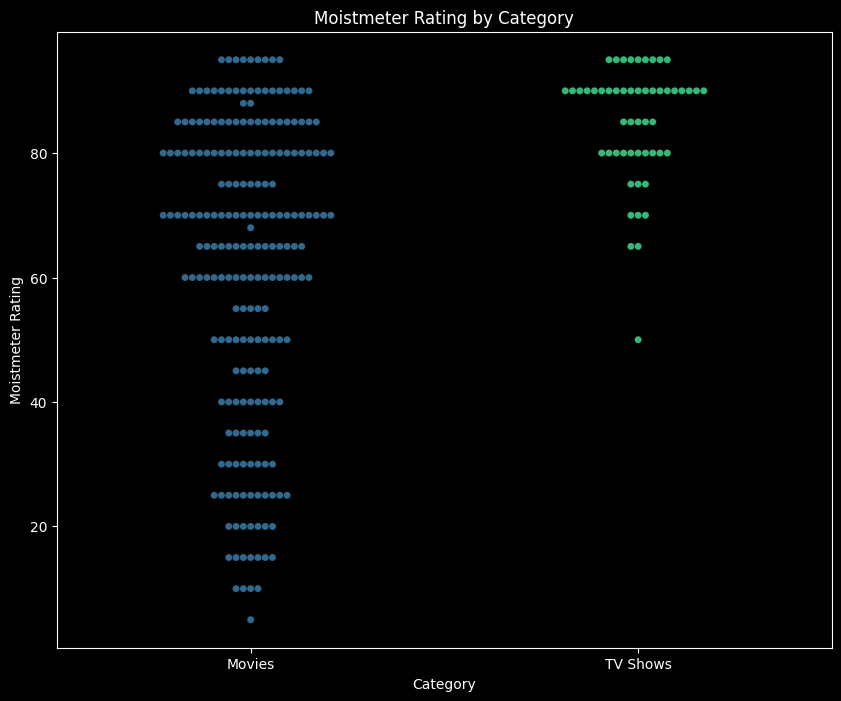

In [39]:
plt.figure(figsize=(10, 8))

sns.swarmplot(x='Category', y='Moistmeter Rating', data=movie_data, palette='viridis')

plt.title('Moistmeter Rating by Category')
plt.xlabel('Category')
plt.ylabel('Moistmeter Rating')

plt.show()

TV Shows apparently receive better ratings than Movies.

In [40]:
#Drop unnecessary columns like Review Date and Title
movie_data = movie_data.drop(['Title', 'Review Date', 'Genre', 'ID'], axis = 1)

#Get dummies to convert categorical variable into dummy/indicator variables.
movie_data = pd.get_dummies(movie_data)
movie_data.head()

,IMDB Rating,RT Critics Rating,Moistmeter Rating,Year,,Action,Adventure,Animation,Biography,Comedy,...,Horror,Music,Mystery,Romance,Sci-Fi,Sci-fi,Short,Thriller,Category_Movies,Category_TV Shows
0,63.0,42.0,70.0,2017,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,True,False
1,64.0,65.0,60.0,2017,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,True,False
2,73.0,93.0,80.0,2017,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,True,False
3,54.0,15.0,50.0,2017,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,True,False
4,52.0,16.0,25.0,2017,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,True,False


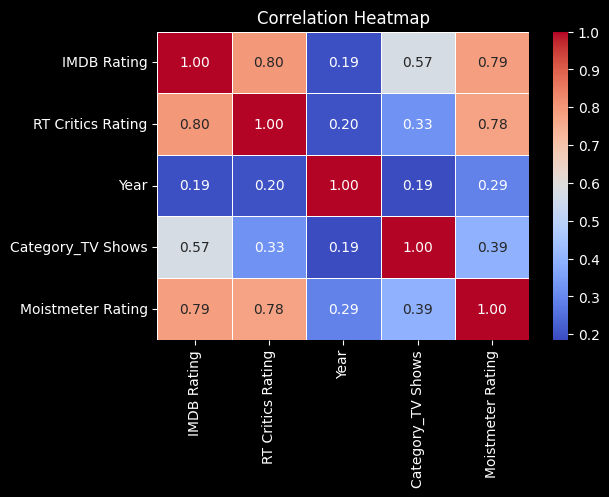

In [41]:
# Dropping one Category column since, one is the negative of the other
movie_data = movie_data.drop('Category_Movies', axis = 1)
selected_features = ['IMDB Rating', 'RT Critics Rating', 'Year', 'Category_TV Shows', 'Moistmeter Rating']

#Plot a heatmap
corr_matrix = movie_data[selected_features].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [42]:
X = movie_data.copy()
y = X.pop('Moistmeter Rating')

From the heatmap, we can see that IMDB Rating and RT Critics Rating are highly correlated, thus we should add a column combining those two. But first, let see the PCA.

In [43]:
# Code from PCA tutorial on Kaggle
from sklearn.decomposition import PCA

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA(n_components = 4)
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [44]:
pca, X_pca, loadings = apply_pca(X)
print(loadings)

                        PC1       PC2       PC3       PC4
IMDB Rating       -0.373070  0.368251 -0.107849  0.002570
RT Critics Rating -0.300786  0.343562 -0.166496 -0.047022
Year              -0.196579  0.059469 -0.136755  0.110783
                   0.010152  0.054957  0.010957 -0.051857
Action            -0.297319 -0.348868 -0.025948  0.139362
Adventure         -0.363156 -0.325747 -0.041576  0.112204
Animation         -0.298747  0.066185 -0.179320 -0.240341
Biography          0.031313  0.249733  0.364667  0.290094
Comedy            -0.077883 -0.010707  0.175334 -0.525742
Crime              0.066746  0.109967  0.090423 -0.228066
Documentary        0.012549  0.118511  0.280427 -0.169604
Drama              0.057540  0.366749  0.107937  0.308652
Family             0.021680  0.024934  0.245620 -0.150502
Fantasy            0.002423 -0.165143  0.090410  0.302342
History           -0.039058  0.266374  0.164727  0.368276
Horror             0.346803  0.094481 -0.343946  0.046568
Music         

In [45]:
movie_data = pd.concat([movie_data.reset_index(drop = True), X_pca], axis=1)
movie_data.head()

,IMDB Rating,RT Critics Rating,Moistmeter Rating,Year,,Action,Adventure,Animation,Biography,Comedy,...,Romance,Sci-Fi,Sci-fi,Short,Thriller,Category_TV Shows,PC1,PC2,PC3,PC4
0,63.0,42.0,70.0,2017,0,1,0,0,0,0,...,0,0,0,0,0,False,1.070115,0.130926,1.137629,-0.046618
1,64.0,65.0,60.0,2017,0,0,0,0,0,0,...,0,1,0,0,1,False,2.711617,-0.491221,-1.350495,0.349745
2,73.0,93.0,80.0,2017,0,1,1,0,0,0,...,0,0,0,0,0,False,-0.930982,-1.141445,0.347378,0.964058
3,54.0,15.0,50.0,2017,0,1,1,0,0,0,...,0,0,0,0,0,False,0.629996,-2.828647,1.048177,1.107322
4,52.0,16.0,25.0,2017,0,0,0,0,0,0,...,0,0,0,1,0,False,2.414716,-0.140030,5.058990,-2.275348


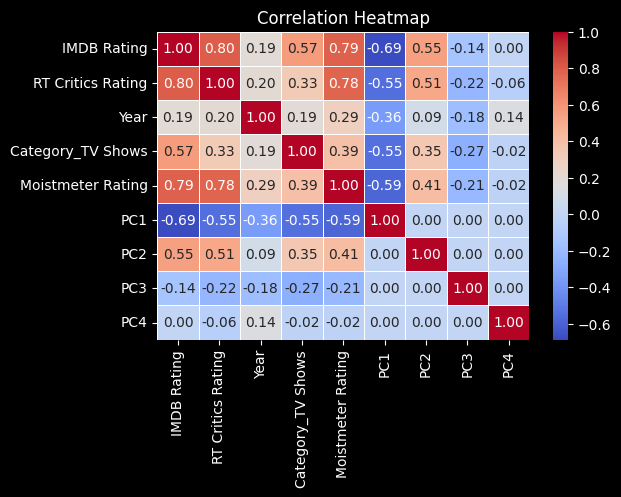

In [46]:
#Plot a heatmap
for n in range(1, 5):
    selected_features.append(f"PC{n}")
corr_matrix = movie_data[selected_features].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

PC1 and PC2 seem to high correlations with the target variable, so we add them into our data

In [47]:
X_pca.drop('PC3', axis = 1, inplace = True)
X_pca.drop('PC4', axis = 1, inplace = True)

X = pd.concat([X.reset_index(drop = True), X_pca], axis=1)
X.head()

,IMDB Rating,RT Critics Rating,Year,,Action,Adventure,Animation,Biography,Comedy,Crime,...,Music,Mystery,Romance,Sci-Fi,Sci-fi,Short,Thriller,Category_TV Shows,PC1,PC2
0,63.0,42.0,2017,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,False,1.070115,0.130926
1,64.0,65.0,2017,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,False,2.711617,-0.491221
2,73.0,93.0,2017,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,False,-0.930982,-1.141445
3,54.0,15.0,2017,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,False,0.629996,-2.828647
4,52.0,16.0,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,False,2.414716,-0.140030


# Model Setup

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
#Since Charlie only give scores divisible by 5, we can apply it to our results
def round_to_nearest_5(x):
    return 5 * round(x / 5)

In [50]:
from sklearn.kernel_ridge import KernelRidge

param_grid = {
    'alpha': [0.1, 1, 10, 100],                  # Regularization strength
    'kernel': ['linear', 'polynomial', 'rbf'],   # Kernel types
    'gamma': [0.001, 0.01, 0.1, 1],              # Kernel coefficient (for 'rbf', 'poly', 'sigmoid')
    'degree': [2, 3, 4],                         # Degree for 'polynomial' kernel
    'coef0': [0, 1, 10]                          # Independent term for 'poly' and 'sigmoid'
}


kr = KernelRidge()
grid_search = GridSearchCV(estimator=kr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'alpha': 0.1, 'coef0': 0, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}


In [51]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

y_pred_rounded = [round_to_nearest_5(pred) for pred in y_pred]
y_pred_rounded = np.array(y_pred_rounded)


rmse = np.sqrt(mean_squared_error(y_test, y_pred_rounded))

print(f"Test set RMSE of KR model: {rmse}")

Test set RMSE of KR model: 11.347844945436133


In [52]:
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_rounded
})

print(comparison_df)


     Actual  Predicted
179    90.0         85
115    85.0         65
96     60.0         55
24     20.0         10
9      35.0         50
139    70.0         75
255    70.0         70
45     50.0         45
185    70.0         85
125    50.0         50
257    25.0         55
173    80.0         80
117    65.0         85
73     25.0         55
211    60.0         60
229    80.0         70
175    80.0         75
196    50.0         45
118    70.0         50
113    80.0         85
60     55.0         70
6      75.0         80
30     70.0         80
208    85.0         80
233    70.0         75
84     70.0         75
66     35.0         30
144    65.0         80
97     85.0         80
159    70.0         60
19     75.0         60
67     30.0         40
114    75.0         70
104    70.0         85
150    70.0         85
82     70.0         65
213    90.0         90
15      5.0         30
46     60.0         75
236    75.0         75
242    80.0         75
33     20.0         35
154    80.0

The model's performance was below expectations, likely due to the dataset's limited size of around 260 rows and some flaws in my approach. Given that I've only spent two weeks learning on Kaggle, I believe there's plenty of room for improvement. I hope anyone using this dataset enjoys exploring it as much as I did while collecting the data and conducting some playful analysis. Thank you!